## Trigger rate plots
Using updated database with processed additional events

In [1]:
import sys
import os
import subprocess
import re
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql
import getpass
import matplotlib as mpl
import argparse
import hashlib
import collections
from sklearn.externals import joblib

mpl.rcParams['figure.dpi'] = 80

import matplotlib.pyplot as plt
import seaborn as sns

app_base_dir = '/home/spbproc/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

import event_processing_v3
import event_processing_v4
import postgresql_v3_event_storage
import dataset_query_functions_v3

import tool.acqconv

from data_analysis_utils import *
# from data_analysis_utils_performance import *
from data_analysis_utils_trigger_rate import *
# import supervised_classification as supc    
from utility_funtions import key_vals2val_keys

Welcome to JupyROOT 6.13/02


In [2]:
data_snippets_dir = 'trigger_rate_figures_flight_20190618'
figures_dir = os.path.join(data_snippets_dir, 'figures')
def fig_path(name, figures_dir=figures_dir):
    return os.path.join(figures_dir, name)
os.makedirs(data_snippets_dir, exist_ok=True)
os.makedirs(os.path.join(data_snippets_dir, 'figures'), exist_ok=True)

In [3]:
DATASETS_DICT = {}

## Flat fielded database data

In [4]:
event_processing_cls = event_processing_v4.EventProcessingV4
event_v3_storage_provider_flight = dataset_query_functions_v3.build_event_v3_storage_provider(
    event_storage_provider_config_file=os.path.join(app_base_dir,'config_w_flatmap.ini'), 
    table_names_version='ver4',
    event_storage_class=postgresql_v3_event_storage.PostgreSqlEventV3StorageProvider,
    event_processing_class=event_processing_cls
)

query_functions_flight = dataset_query_functions_v3.Ver3DatasetQueryFunctions(event_v3_storage_provider_flight)

In [5]:
common_included_columns_re_list = [
  ('^$','source_file_(acquisition|trigger)(_full)?|global_gtu|packet_id|gtu_in_packet|event_id|num_gtu'),
  
  'gtu_datetime_(mean|min|max)',  
  'gps_datetime_(mean|min|max)', 'gps_alt_mean', 'gps_lon_mean', 'gps_lat_mean', 
    
  ('^trg(_box_per_gtu|_pmt_per_gtu|_ec_per_gtu)?$', '^(count_nonzero|min|max|sum|mean|size)$'),
  ('^(bg|orig)(_x_y)?$','^(mean_gz|mean|max|min|sum)$'),
    
#   '(proc\d|trg|alt\d)_(x|gtu)_(x|y)_hough_peak_thr2_max_clu_major_line_phi',
    
]

In [6]:
flight_columns_for_analysis_dict = query_functions_flight.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=('^.+$',),
    default_excluded_columns_re_list=[],
    included_columns_re_list=common_included_columns_re_list
)

print_columns_dict(flight_columns_for_analysis_dict)

spb_processing_v4_flatmap.event
	- event_id
	- source_file_acquisition_full
	- source_file_trigger_full
	- source_file_acquisition
	- source_file_trigger
	- global_gtu
	- packet_id
	- gtu_in_packet
	- num_gtu

spb_processing_v4_flatmap.event_trg_box_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4_flatmap.event_trg_pmt_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4_flatmap.event_trg_ec_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4_flatmap.event_gps_lat
	- mean

spb_processing_v4_flatmap.event_gps_lon
	- mean

spb_processing_v4_flatmap.event_gps_alt
	- mean

spb_processing_v4_flatmap.event_gps_datetime
	- max
	- min
	- mean

spb_processing_v4_flatmap.event_gtu_datetime
	- max
	- min
	- mean

spb_processing_v4_flatmap.event_orig_x_y
	- sum
	- min
	- max
	- mean
	- mean_gz

spb_processing_v4_flatmap.event_bg_x_y
	- sum
	- min
	- max
	- mean
	- mean_gz

spb_processing_v4_flatmap.event_trg
	- count_nonzero
	- sum
	- min
	- max
	- mean
	- size

spb_processing_v4_fla

In [7]:
flight_df_columns = query_functions_flight.get_dataframe_columns_from_dict(flight_columns_for_analysis_dict)

### Flat-fielded and bgf=0.5 from database

In [8]:
unl_flight_flatmap_bgf05_key = 'unl_flight_flatmap_bgf05'

In [9]:
# not in the report
current_columns_for_analysis_dict = flight_columns_for_analysis_dict

unl_flight_select_clause_str, unl_flight_tables_list = \
    query_functions_flight.get_query_clauses__select(current_columns_for_analysis_dict)

unl_flight_clauses_str = \
    query_functions_flight.get_query_clauses__join(unl_flight_tables_list)

unl_source_data_type_num = 1

unl_flight_where_clauses_str = ''' 
''' 

unl_flight_events_selection_query = \
    query_functions_flight.get_events_selection_query_plain(
        source_data_type_num=unl_source_data_type_num,
        select_additional=unl_flight_select_clause_str, 
        join_additional=unl_flight_clauses_str,
        where_additional=unl_flight_where_clauses_str,
        order_by='{data_table_name}.event_id', 
        offset=0, 
#         limit=20000,                            # intentionally selecting incomplete subset to save memory !!!!!!!!!!!!!
        limit=500000,
        base_select='')

# print(unl_flight_events_selection_query)

DATASETS_DICT[unl_flight_flatmap_bgf05_key] = {
    'df': psql.read_sql(unl_flight_events_selection_query, event_v3_storage_provider_flight.connection)
}

In [10]:
len(DATASETS_DICT[unl_flight_flatmap_bgf05_key]['df'])

247316

In [11]:
# DATASETS_DICT[unl_flight_flatmap_bgf05_key]['by_datetime_df'] = \
#     DATASETS_DICT[unl_flight_flatmap_bgf05_key]['df'].sort_values('gtu_datetime_min', ascending=True)

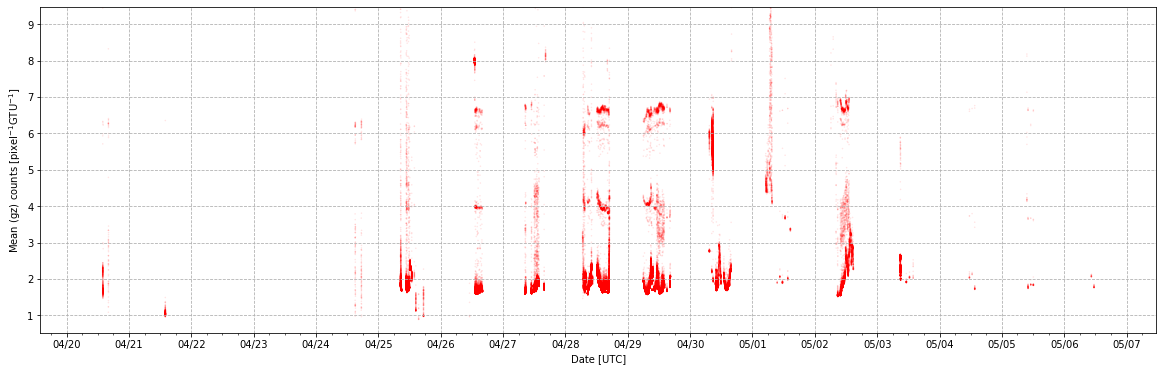

In [12]:
vis_trigger_rate(
    DATASETS_DICT[unl_flight_flatmap_bgf05_key]['df']['gps_datetime_min'].tolist(), 
    DATASETS_DICT[unl_flight_flatmap_bgf05_key]['df']['orig_mean_gz'].tolist(), 
    None,
    ax=None, show=True, ylabel='Mean (gz) counts [pixel$^{-1}$GTU$^{-1}$]',
    marker='.', alpha=.1, color='red', s=10, label=None, yscale='linear',
    ylim=(1,9),
    base_figure_pathname=fig_path('unl_flight_flatmap_bgf05_mean_counts')
#     ylim=(unl_flight_df__by_datetime['orig_mean_gz'].min(), 
#           unl_flight_df__by_datetime['orig_mean_gz'].quantile(q=0.997))
);

In [13]:
trigger_datetime_list, trigger_rate_list = \
    count_trigger_rate_per_file_from_df(DATASETS_DICT[unl_flight_flatmap_bgf05_key]['df'],  one_trg_per='packet')

DATASETS_DICT[unl_flight_flatmap_bgf05_key]['trigger_datetime_list'] = trigger_datetime_list
DATASETS_DICT[unl_flight_flatmap_bgf05_key]['trigger_rate_list'] = trigger_rate_list

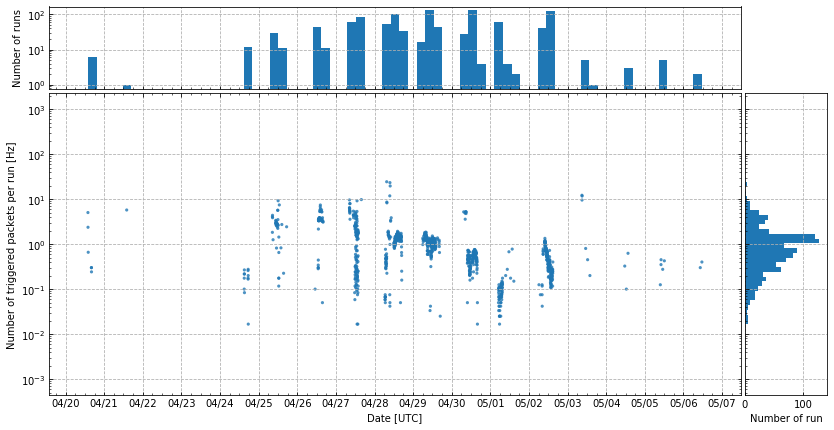

In [14]:
vis_trigger_rate_w_distributions(
    DATASETS_DICT[unl_flight_flatmap_bgf05_key]['trigger_datetime_list'], 
    DATASETS_DICT[unl_flight_flatmap_bgf05_key]['trigger_rate_list'], 
    ylim=(10**(-2.5), 10**(2.5)),
    base_figure_pathname=fig_path('unl_flight_flatmap_bgf05_trg_rate_1_per_packet'),
    figsize=(12, 6),
#     ylim=(DATASETS_DICT[unl_flight_flatmap_bgf05_key]['by_datetime_df'].min(), 
#           DATASETS_DICT[unl_flight_flatmap_bgf05_key]['by_datetime_df'].quantile(q=0.997))
);

### Flat-fielded and bgf=1.0 from database

In [15]:
unl_flight_flatmap_bgf1_key = 'unl_flight_flatmap_bgf1'

In [16]:
# not in the report
current_columns_for_analysis_dict = flight_columns_for_analysis_dict

unl_flight_select_clause_str, unl_flight_tables_list = \
    query_functions_flight.get_query_clauses__select(current_columns_for_analysis_dict)

unl_flight_clauses_str = \
    query_functions_flight.get_query_clauses__join(unl_flight_tables_list)

unl_source_data_type_num = 8

unl_flight_where_clauses_str = ''' 
''' 

unl_flight_events_selection_query = \
    query_functions_flight.get_events_selection_query_plain(
        source_data_type_num=unl_source_data_type_num,
        select_additional=unl_flight_select_clause_str, 
        join_additional=unl_flight_clauses_str,
        where_additional=unl_flight_where_clauses_str,
        order_by='{data_table_name}.event_id', 
        offset=0, 
#         limit=20000,                            # intentionally selecting incomplete subset to save memory !!!!!!!!!!!!!
        limit=500000,
        base_select='')

# print(unl_flight_events_selection_query)


DATASETS_DICT[unl_flight_flatmap_bgf1_key] = {
    'df': psql.read_sql(unl_flight_events_selection_query, event_v3_storage_provider_flight.connection)
}

In [17]:
len(DATASETS_DICT[unl_flight_flatmap_bgf1_key]['df'])

90587

In [18]:
# DATASETS_DICT[unl_flight_flatmap_bgf1_key]['by_datetime_df'] = \
#     DATASETS_DICT[unl_flight_flatmap_bgf1_key]['df'].sort_values('gtu_datetime_min', ascending=True)

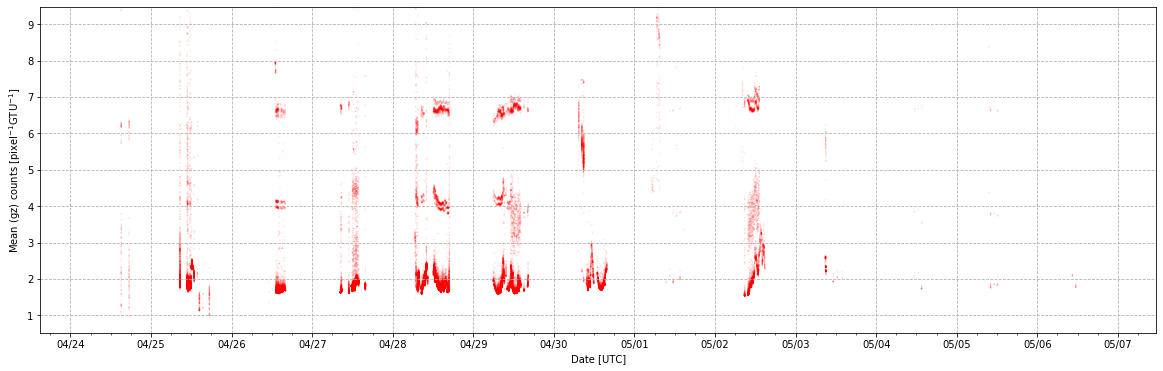

In [19]:
vis_trigger_rate(
    DATASETS_DICT[unl_flight_flatmap_bgf1_key]['df']['gps_datetime_min'].tolist(), 
    DATASETS_DICT[unl_flight_flatmap_bgf1_key]['df']['orig_mean_gz'].tolist(), 
    None,
    ax=None, show=True, ylabel='Mean (gz) counts [pixel$^{-1}$GTU$^{-1}$]',
    marker='.', alpha=.1, color='red', s=10, label=None, yscale='linear',
    ylim=(1,9),
    base_figure_pathname=fig_path('unl_flight_flatmap_bgf1_mean_counts')
#     ylim=(unl_flight_df__by_datetime['orig_mean_gz'].min(), 
#           unl_flight_df__by_datetime['orig_mean_gz'].quantile(q=0.997))
)

In [20]:
trigger_datetime_list, trigger_rate_list = \
    count_trigger_rate_per_file_from_df(DATASETS_DICT[unl_flight_flatmap_bgf1_key]['df'],  one_trg_per='packet')

DATASETS_DICT[unl_flight_flatmap_bgf1_key]['trigger_datetime_list'] = trigger_datetime_list
DATASETS_DICT[unl_flight_flatmap_bgf1_key]['trigger_rate_list'] = trigger_rate_list

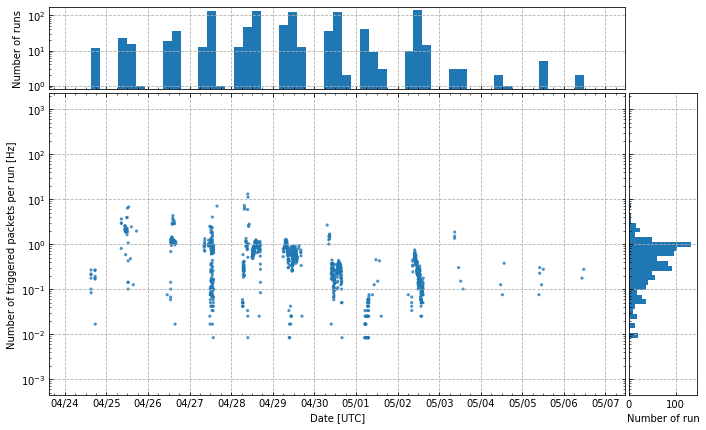

In [21]:
vis_trigger_rate_w_distributions(
    DATASETS_DICT[unl_flight_flatmap_bgf1_key]['trigger_datetime_list'], 
    DATASETS_DICT[unl_flight_flatmap_bgf1_key]['trigger_rate_list'],
    ylim=(10**(-2.5), 10**(2.5)),
    base_figure_pathname=fig_path('unl_flight_flatmap_bgf1_trg_rate_1_per_packet'),
);

### Comparison of trigger rates between $\textrm{bgf}=0.5$ and $\textrm{bgf}=1$

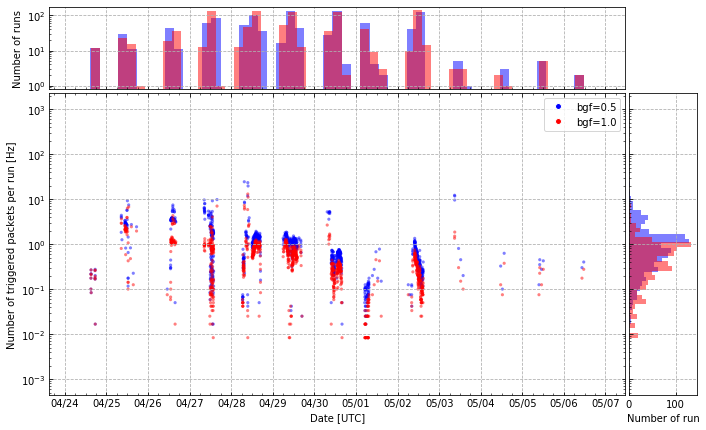

In [22]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        DATASETS_DICT[unl_flight_flatmap_bgf05_key]['trigger_datetime_list'], 
        DATASETS_DICT[unl_flight_flatmap_bgf05_key]['trigger_rate_list'], 
        figsize=(10, 6),
        ylim=(10**(-2.5), 10**(2.5)),
        label='bgf=0.5', color='blue', hist_alpha=.5, scatter_alpha=.5,
        show=False
    )

vis_trigger_rate_w_distributions(
    DATASETS_DICT[unl_flight_flatmap_bgf1_key]['trigger_datetime_list'], 
    DATASETS_DICT[unl_flight_flatmap_bgf1_key]['trigger_rate_list'],
    ylim=(10**(-2.5), 10**(2.5)), 
    label='bgf=1.0',color='red', hist_alpha=.5, scatter_alpha=.5,
    base_figure_pathname=fig_path('unl_flight_flatmap_comparison_bgf05_and_bgf1_trg_rate_1_per_packet'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    figsize=(10, 6),
    legend=True,
    show=True
);

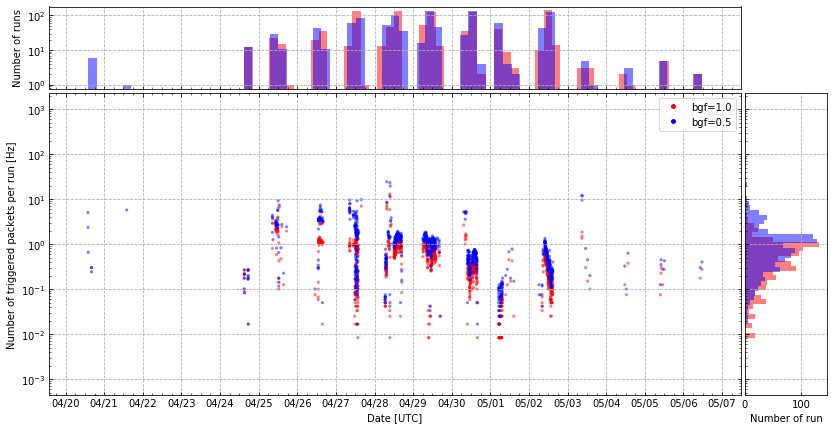

In [23]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions( 
        DATASETS_DICT[unl_flight_flatmap_bgf1_key]['trigger_datetime_list'], 
        DATASETS_DICT[unl_flight_flatmap_bgf1_key]['trigger_rate_list'],
        ylim=(10**(-2.5), 10**(2.5)),
        label='bgf=1.0', color='red', hist_alpha=.5, scatter_alpha=.5,
        figsize=(12, 6),
        show=False
    )

vis_trigger_rate_w_distributions(
    DATASETS_DICT[unl_flight_flatmap_bgf05_key]['trigger_datetime_list'], 
    DATASETS_DICT[unl_flight_flatmap_bgf05_key]['trigger_rate_list'],
    ylim=(10**(-2.5), 10**(2.5)), 
    label='bgf=0.5',color='blue', hist_alpha=.5, scatter_alpha=.5,
    base_figure_pathname=fig_path('unl_flight_flatmap_comparison_bgf05_and_bgf1_trg_rate_1_per_packet_blue_on_top'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    figsize=(12, 6),
    legend=True,
    show=True
);

## Trigger rates from l1trg (TrigVisKenji) with default $P$, $R$ configuration

### $\textrm{bgf}=0.5$ with flat field map

In [24]:
l1trg_files_bgf05_with_flatmap_key = 'l1trg_files_bgf05_with_flatmap'

In [25]:
#!cat trigger_rate_for_l1trg/bgf1_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_info.txt

In [26]:
df = pd.DataFrame()
df['trigger_num_per_file'] = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_num_per_file.pkl')
df['trigger_rate_per_file'] = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_rate_per_file.pkl')
df['file_trigger_datetimes'] = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_datetimes.pkl')
df['file_trigger_p_r'] = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_p_r.pkl')
df['file_trigger_timedelta'] = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_timedelta.pkl')
df['file_indices'] = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_indices.pkl')

DATASETS_DICT[l1trg_files_bgf05_with_flatmap_key] = {'lists_df': df}

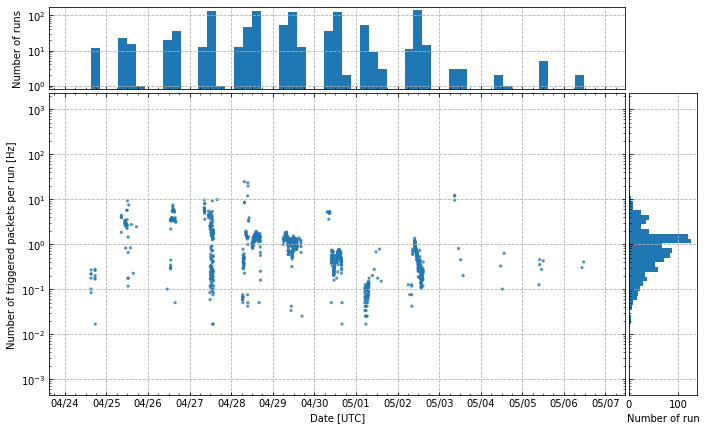

In [27]:
vis_trigger_rate_w_distributions(
    DATASETS_DICT[l1trg_files_bgf05_with_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
    DATASETS_DICT[l1trg_files_bgf05_with_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
    ylim=(10**(-2.5), 10**(2.5)),
    base_figure_pathname=fig_path(l1trg_files_bgf05_with_flatmap_key + '_trg_rate_1_per_packet')
);

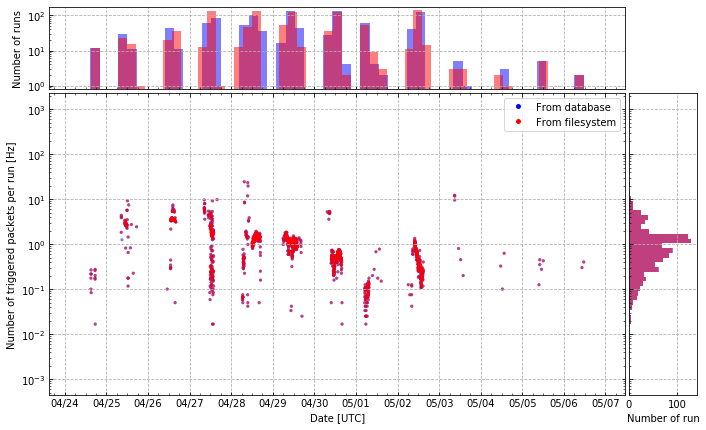

In [28]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        DATASETS_DICT[unl_flight_flatmap_bgf05_key]['trigger_datetime_list'], 
        DATASETS_DICT[unl_flight_flatmap_bgf05_key]['trigger_rate_list'], 
        ylim=(10**(-2.5), 10**(2.5)),
        label='From database', color='blue', hist_alpha=.5, scatter_alpha=.5,
        show=False
    )

vis_trigger_rate_w_distributions(
    DATASETS_DICT[l1trg_files_bgf05_with_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
    DATASETS_DICT[l1trg_files_bgf05_with_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
    ylim=(10**(-2.5), 10**(2.5)), 
    label='From filesystem',color='red', hist_alpha=.5, scatter_alpha=.5,
    base_figure_pathname=fig_path('unl_flight_flatmap_comparison_db_bgf05_and_l1trg_bgf05_trg_rate_1_per_packet'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True,
    show=True
);

### $\textrm{bgf}=0.5$ without flat field map

In [29]:
#!cat trigger_rate_for_l1trg/bgf05_no_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_info.txt

In [30]:
l1trg_files_bgf05_no_flatmap_key = 'l1trg_files_bgf05_no_flatmap'

In [31]:
df = pd.DataFrame()
df['trigger_num_per_file'] = joblib.load('trigger_rate_for_l1trg/bgf05_no_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_num_per_file.pkl')
df['trigger_rate_per_file'] = joblib.load('trigger_rate_for_l1trg/bgf05_no_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_rate_per_file.pkl')
df['file_trigger_datetimes'] = joblib.load('trigger_rate_for_l1trg/bgf05_no_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_datetimes.pkl')
df['file_trigger_p_r'] = joblib.load('trigger_rate_for_l1trg/bgf05_no_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_p_r.pkl')
df['file_trigger_timedelta'] = joblib.load('trigger_rate_for_l1trg/bgf05_no_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_timedelta.pkl')
df['file_indices'] = joblib.load('trigger_rate_for_l1trg/bgf05_no_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_indices.pkl')

DATASETS_DICT[l1trg_files_bgf05_no_flatmap_key] = {'lists_df': df}

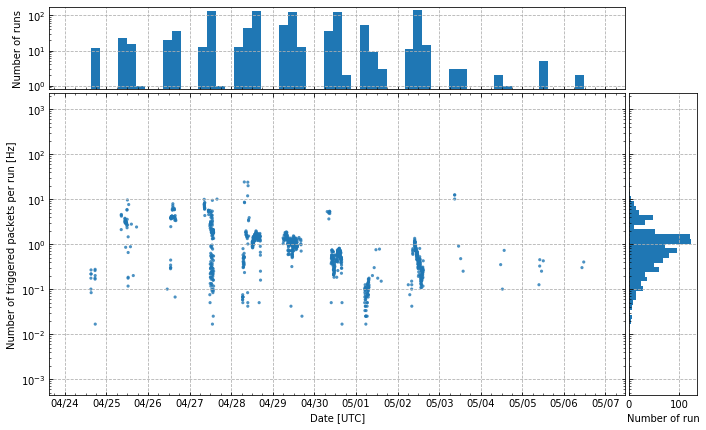

In [32]:
vis_trigger_rate_w_distributions(
    DATASETS_DICT[l1trg_files_bgf05_no_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
    DATASETS_DICT[l1trg_files_bgf05_no_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
    ylim=(10**(-2.5), 10**(2.5)),
    base_figure_pathname=fig_path(l1trg_files_bgf05_no_flatmap_key + '_trg_rate_1_per_packet')
);

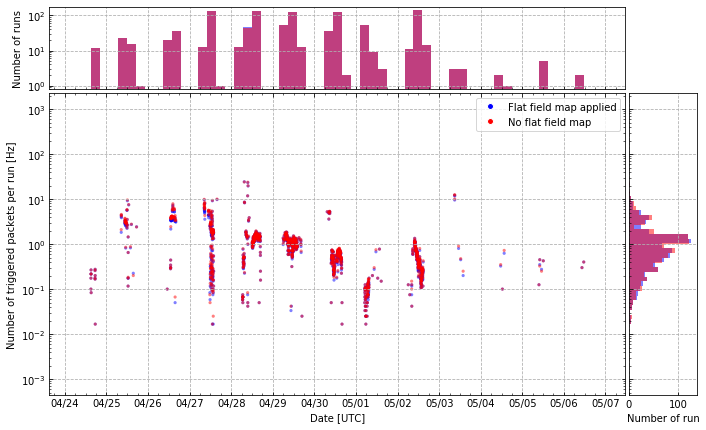

In [33]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        DATASETS_DICT[l1trg_files_bgf05_with_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
        DATASETS_DICT[l1trg_files_bgf05_with_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
        ylim=(10**(-2.5), 10**(2.5)),
        label='Flat field map applied', color='blue', hist_alpha=.5, scatter_alpha=.5,
        show=False
    )

vis_trigger_rate_w_distributions(
    DATASETS_DICT[l1trg_files_bgf05_no_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
    DATASETS_DICT[l1trg_files_bgf05_no_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
    ylim=(10**(-2.5), 10**(2.5)), 
    label='No flat field map',color='red', hist_alpha=.5, scatter_alpha=.5,
    base_figure_pathname=fig_path('unl_flight_flatmap_comparison_l1trg_bgf05_flatmap_yes_no_trg_rate_1_per_packet'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True,
    show=True
);

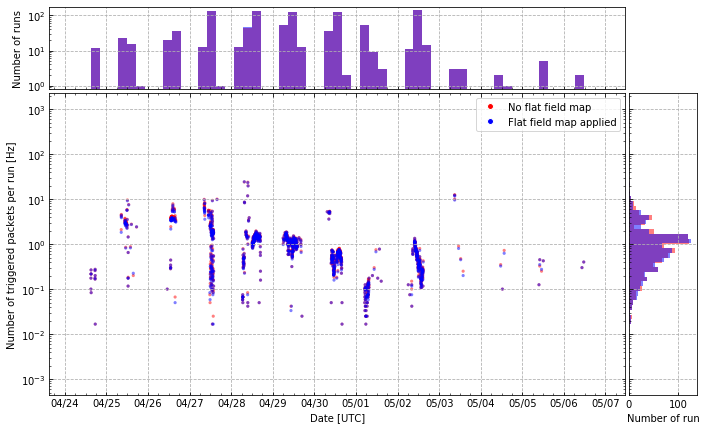

In [34]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        DATASETS_DICT[l1trg_files_bgf05_no_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
        DATASETS_DICT[l1trg_files_bgf05_no_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
        ylim=(10**(-2.5), 10**(2.5)),
        label='No flat field map',color='red', hist_alpha=.5, scatter_alpha=.5,
        show=False
    )

vis_trigger_rate_w_distributions(
    DATASETS_DICT[l1trg_files_bgf05_with_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
    DATASETS_DICT[l1trg_files_bgf05_with_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Flat field map applied', color='blue', hist_alpha=.5, scatter_alpha=.5,
    base_figure_pathname=fig_path('unl_flight_flatmap_comparison_l1trg_bgf05_flatmap_yes_no_trg_rate_1_per_packet_blue_on_top'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True,
    show=True
);

### $\textrm{bgf}=1$ with flat field map

In [35]:
#!trigger_rate_for_l1trg/bgf1_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_info.txt

In [36]:
l1trg_files_bgf1_with_flatmap_key = 'l1trg_files_bgf1_with_flatmap'

In [37]:
df = pd.DataFrame()
df['trigger_num_per_file'] = joblib.load('trigger_rate_for_l1trg/bgf1_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_num_per_file.pkl')
df['trigger_rate_per_file'] = joblib.load('trigger_rate_for_l1trg/bgf1_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_rate_per_file.pkl')
df['file_trigger_datetimes'] = joblib.load('trigger_rate_for_l1trg/bgf1_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_datetimes.pkl')
df['file_trigger_p_r'] = joblib.load('trigger_rate_for_l1trg/bgf1_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_p_r.pkl')
df['file_trigger_timedelta'] = joblib.load('trigger_rate_for_l1trg/bgf1_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_timedelta.pkl')
df['file_indices'] = joblib.load('trigger_rate_for_l1trg/bgf1_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_indices.pkl')

DATASETS_DICT[l1trg_files_bgf1_with_flatmap_key] = {'lists_df': df}

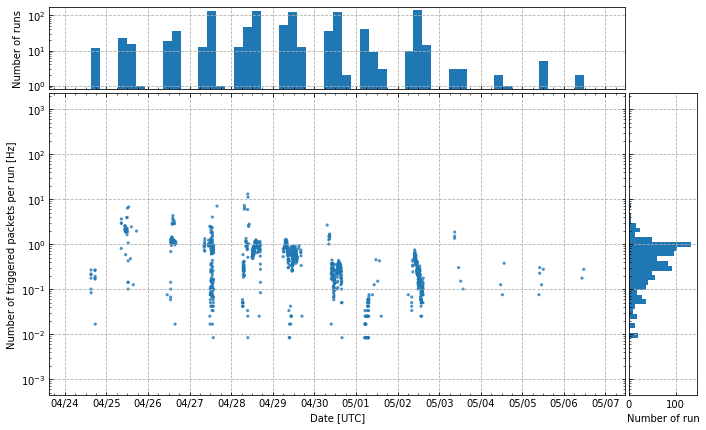

In [38]:
vis_trigger_rate_w_distributions(
    DATASETS_DICT[l1trg_files_bgf1_with_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
    DATASETS_DICT[l1trg_files_bgf1_with_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
    ylim=(10**(-2.5), 10**(2.5)),
    base_figure_pathname=fig_path(l1trg_files_bgf1_with_flatmap_key + '_trg_rate_1_per_packet')
);

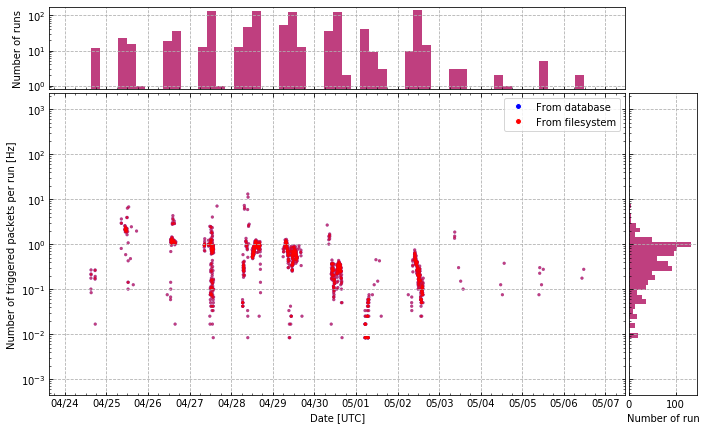

In [39]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        DATASETS_DICT[unl_flight_flatmap_bgf1_key]['trigger_datetime_list'], 
        DATASETS_DICT[unl_flight_flatmap_bgf1_key]['trigger_rate_list'], 
        ylim=(10**(-2.5), 10**(2.5)),
        label='From database', color='blue', hist_alpha=.5, scatter_alpha=.5,
        show=False
    )

vis_trigger_rate_w_distributions(
    DATASETS_DICT[l1trg_files_bgf1_with_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
    DATASETS_DICT[l1trg_files_bgf1_with_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
    ylim=(10**(-2.5), 10**(2.5)), 
    label='From filesystem',color='red', hist_alpha=.5, scatter_alpha=.5,
    base_figure_pathname=fig_path('unl_flight_flatmap_comparison_db_bgf1_and_l1trg_bgf1_trg_rate_1_per_packet'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True,
    show=True
);

### $\textrm{bgf}=1$ without flat field map

In [40]:
l1trg_files_bgf1_no_flatmap_key = 'l1trg_files_bgf1_no_flatmap'

In [41]:
df = pd.DataFrame()
df['trigger_num_per_file'] = joblib.load('trigger_rate_for_l1trg/bgf1_no_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_num_per_file.pkl')
df['trigger_rate_per_file'] = joblib.load('trigger_rate_for_l1trg/bgf1_no_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_rate_per_file.pkl')
df['file_trigger_datetimes'] = joblib.load('trigger_rate_for_l1trg/bgf1_no_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_datetimes.pkl')
df['file_trigger_p_r'] = joblib.load('trigger_rate_for_l1trg/bgf1_no_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_p_r.pkl')
df['file_trigger_timedelta'] = joblib.load('trigger_rate_for_l1trg/bgf1_no_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_timedelta.pkl')
df['file_indices'] = joblib.load('trigger_rate_for_l1trg/bgf1_no_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_indices.pkl')


DATASETS_DICT[l1trg_files_bgf1_no_flatmap_key] = {'lists_df': df}

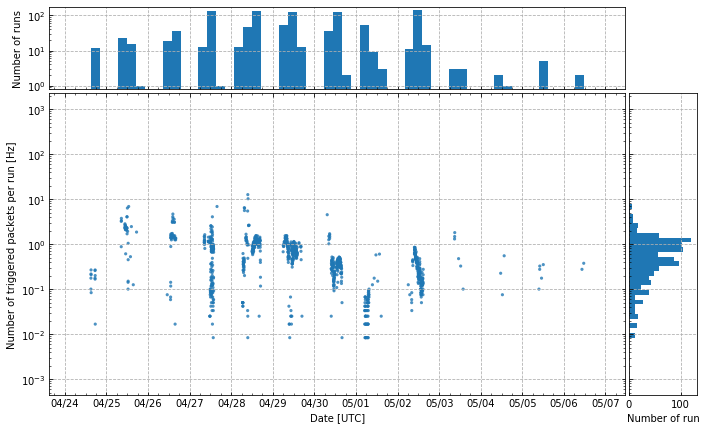

In [42]:
vis_trigger_rate_w_distributions(
    DATASETS_DICT[l1trg_files_bgf1_no_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
    DATASETS_DICT[l1trg_files_bgf1_no_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
    ylim=(10**(-2.5), 10**(2.5)),
    base_figure_pathname=fig_path(l1trg_files_bgf1_no_flatmap_key + '_trg_rate_1_per_packet')
);

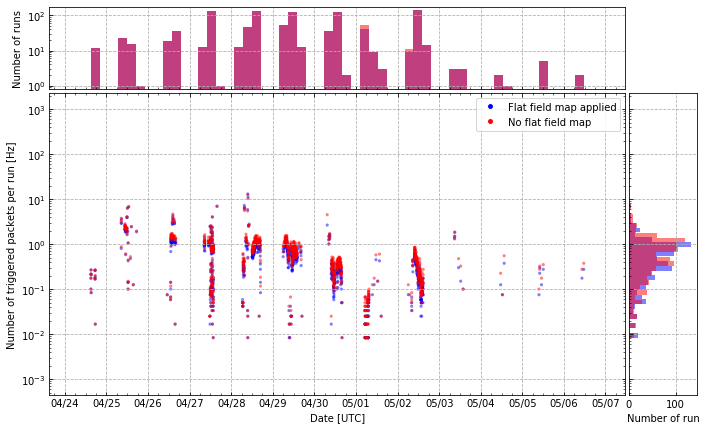

In [43]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        DATASETS_DICT[l1trg_files_bgf1_with_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
        DATASETS_DICT[l1trg_files_bgf1_with_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
        ylim=(10**(-2.5), 10**(2.5)),
        label='Flat field map applied', color='blue', hist_alpha=.5, scatter_alpha=.5,
        show=False
    )

vis_trigger_rate_w_distributions(
    DATASETS_DICT[l1trg_files_bgf1_no_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
    DATASETS_DICT[l1trg_files_bgf1_no_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
    ylim=(10**(-2.5), 10**(2.5)), 
    label='No flat field map',color='red', hist_alpha=.5, scatter_alpha=.5,
    base_figure_pathname=fig_path('unl_flight_flatmap_comparison_l1trg_bgf1_flatmap_yes_no_trg_rate_1_per_packet'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True,
    show=True
);

## Hardware data

In [44]:
hw_data_key = 'hw_trg'

In [45]:
# def filter_func(f,d): 
#     r = os.path.splitext(f)[1] == ".root" and "ACQUISITION" in os.path.basename(f) and re.search(r'SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170(42[4-9]|430|5\d+)$',d) is not None
#     return r

# processed_files = sorted([os.path.join(dp, f) for dp, dn, fn in os.walk(files_dir_abspath) for f in fn if filter_func(f,dp)])

# otgpp_file_trigger_datetime_list, otgpp_file_timedelta_list, otgpp_file_trigger_p_r_list, otgpp_trigger_num_per_file_list, otgpp_file_trigger_rate_list, otgpp_file_indices_list, \
# otgpp_trigger_num_per_file_list_pathname, otgpp_trigger_rate_per_file_list_pathname, otgpp_file_trigger_datetimes_list_pathname, \
# otgpp_file_trigger_p_r_list_pathname, otgpp_file_trigger_timedelta_list_pathname, otgpp_file_indices_list_pathname = \
#     count_trigger_rate_per_file(
#         processed_files, 
#         file_name_prefix='hw', trg_type='hw', one_trg_per_packet=True, 
#         data_snippets_dir=data_snippets_dir, return_filenames=True
#     )

loading data generated by trigger_rate_for_l1trg 

In [46]:
!cat trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_info.txt                

processed_files_hash = 2feee3b0332fbd7fea6241885d90f2aa
trigger_num_per_file_list_pathname = trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_num_per_file.pkl
trigger_rate_per_file_list_pathname = trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_rate_per_file.pkl
file_trigger_datetimes_list_pathname = trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_datetimes.pkl
file_trigger_p_r_list_pathname = trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_p_r.pkl
file_trigger_timedelta_list_pathname = trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_timedelta.pkl
file_indices_list_pathname = trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_indices.pkl
info_pathname = trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2a

In [47]:
df = pd.DataFrame()
df['trigger_num_per_file'] = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_num_per_file.pkl')
df['trigger_rate_per_file'] = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_rate_per_file.pkl')
df['file_trigger_datetimes'] = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_datetimes.pkl')
df['file_trigger_p_r'] = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_p_r.pkl')
df['file_trigger_timedelta'] = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_timedelta.pkl')
df['file_indices'] = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_indices.pkl')

DATASETS_DICT[hw_data_key] = {'lists_df': df}

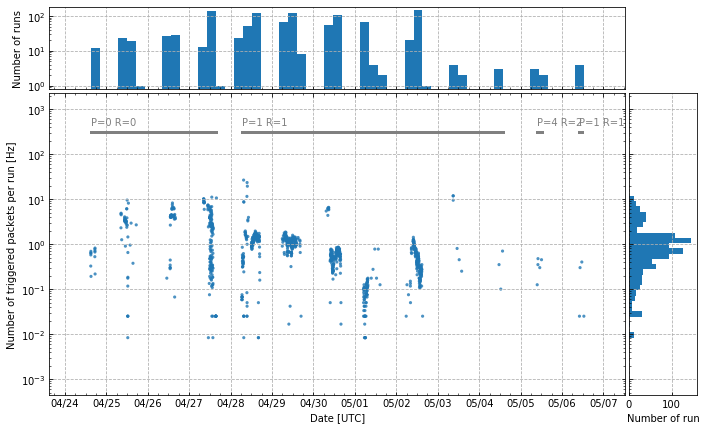

In [48]:
vis_trigger_rate_w_distributions(
    DATASETS_DICT[hw_data_key]['lists_df']['file_trigger_datetimes'].tolist(), 
    DATASETS_DICT[hw_data_key]['lists_df']['trigger_rate_per_file'].tolist(),
    DATASETS_DICT[hw_data_key]['lists_df']['file_trigger_p_r'].tolist(),
    ylim=(10**(-2.5), 10**(2.5)),
    base_figure_pathname=fig_path('hw_trg_rate_1_per_packet')
);

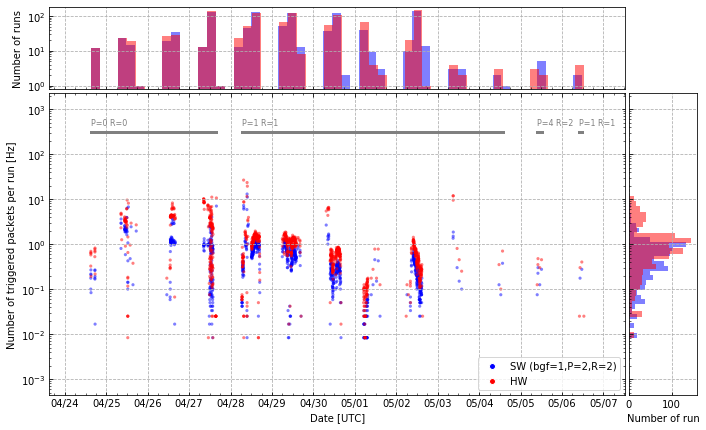

In [54]:
plt.close('all')
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        DATASETS_DICT[unl_flight_flatmap_bgf1_key]['trigger_datetime_list'], 
        DATASETS_DICT[unl_flight_flatmap_bgf1_key]['trigger_rate_list'], 
        ylim=(10**(-2.5), 10**(2.5)),
        label='SW (bgf=1,P=2,R=2)', color='blue', hist_alpha=.5, scatter_alpha=.5,
        show=False
    )

vis_trigger_rate_w_distributions(
    DATASETS_DICT[hw_data_key]['lists_df']['file_trigger_datetimes'].tolist(), 
    DATASETS_DICT[hw_data_key]['lists_df']['trigger_rate_per_file'].tolist(),
    DATASETS_DICT[hw_data_key]['lists_df']['file_trigger_p_r'].tolist(),
    ylim=(10**(-2.5), 10**(2.5)), 
    label='HW',color='red', hist_alpha=.5, scatter_alpha=.5,
    vis_trigger_rate_kwargs={'text_params': {'fontsize':8}},
    base_figure_pathname=fig_path('comparison_db_bgf1_p2r2_and_hw_trg_rate_1_per_packet'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True
);

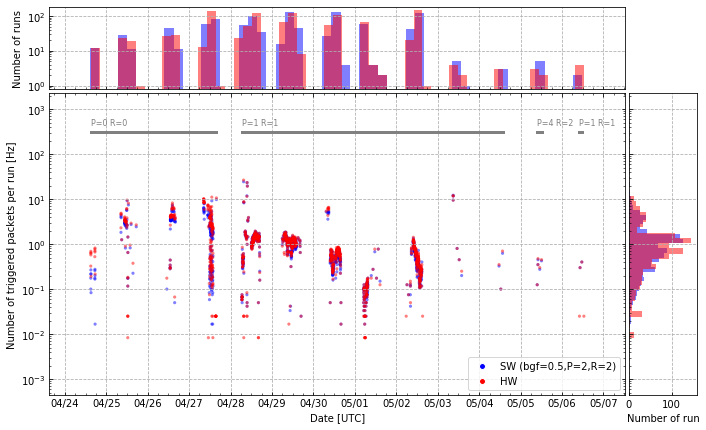

In [55]:
plt.close('all')
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        DATASETS_DICT[unl_flight_flatmap_bgf05_key]['trigger_datetime_list'], 
        DATASETS_DICT[unl_flight_flatmap_bgf05_key]['trigger_rate_list'], 
        ylim=(10**(-2.5), 10**(2.5)),
        label='SW (bgf=0.5,P=2,R=2)', color='blue', hist_alpha=.5, scatter_alpha=.5,
        show=False
    )

vis_trigger_rate_w_distributions(
    DATASETS_DICT[hw_data_key]['lists_df']['file_trigger_datetimes'].tolist(), 
    DATASETS_DICT[hw_data_key]['lists_df']['trigger_rate_per_file'].tolist(),
    DATASETS_DICT[hw_data_key]['lists_df']['file_trigger_p_r'].tolist(),
    ylim=(10**(-2.5), 10**(2.5)), 
    label='HW',color='red', hist_alpha=.5, scatter_alpha=.5,
    vis_trigger_rate_kwargs={'text_params': {'fontsize':8}},
    base_figure_pathname=fig_path('comparison_db_bgf05_p2r2_and_hw_trg_rate_1_per_packet'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True
);

## Trigger rates from l1trg (TrigVisKenji) with various $P$, $R$ configurations (from node15)
<big>Presently not entirely valid</big>

### $P=1$, $R=1$, $\textrm{bgf}=1$  without flat field map 

In [56]:
l1trg_files_bgf1_p1r1_no_flatmap_key = 'l1trg_files_bgf1_p1r1_no_flatmap'

In [57]:
#!cat trigger_rate_for_l1trg/bg1p1r1_no_flatmapf57b7fcddde3b2444cd0e3e579e47ebf_one_trg_per_packet_128_info.txt

In [58]:
df = pd.DataFrame()
df['trigger_num_per_file'] = joblib.load('node15/trigger_rate_for_l1trg/bg1p1r1_no_flatmapf57b7fcddde3b2444cd0e3e579e47ebf_one_trg_per_packet_128_trigger_num_per_file.pkl')
df['trigger_rate_per_file'] = joblib.load('node15/trigger_rate_for_l1trg/bg1p1r1_no_flatmapf57b7fcddde3b2444cd0e3e579e47ebf_one_trg_per_packet_128_trigger_rate_per_file.pkl')
df['file_trigger_datetimes'] = joblib.load('node15/trigger_rate_for_l1trg/bg1p1r1_no_flatmapf57b7fcddde3b2444cd0e3e579e47ebf_one_trg_per_packet_128_file_trigger_datetimes.pkl')
df['file_trigger_p_r'] = joblib.load('node15/trigger_rate_for_l1trg/bg1p1r1_no_flatmapf57b7fcddde3b2444cd0e3e579e47ebf_one_trg_per_packet_128_file_trigger_p_r.pkl')
df['file_trigger_timedelta'] = joblib.load('node15/trigger_rate_for_l1trg/bg1p1r1_no_flatmapf57b7fcddde3b2444cd0e3e579e47ebf_one_trg_per_packet_128_file_trigger_timedelta.pkl')
df['file_indices'] = joblib.load('node15/trigger_rate_for_l1trg/bg1p1r1_no_flatmapf57b7fcddde3b2444cd0e3e579e47ebf_one_trg_per_packet_128_file_indices.pkl')

DATASETS_DICT[l1trg_files_bgf1_p1r1_no_flatmap_key] = {'lists_df': df}

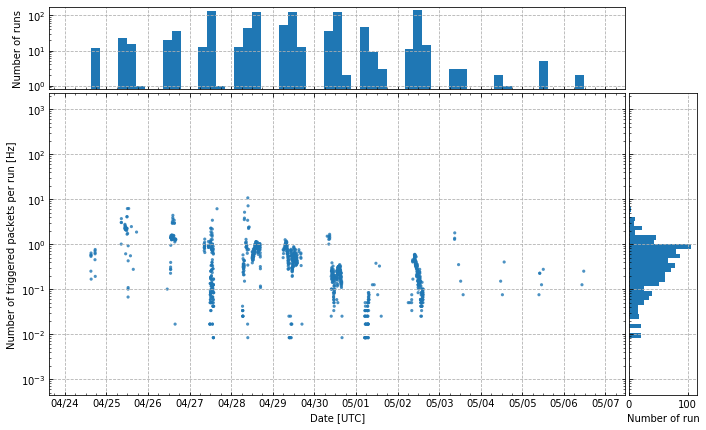

In [59]:
vis_trigger_rate_w_distributions(
    DATASETS_DICT[l1trg_files_bgf1_p1r1_no_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
    DATASETS_DICT[l1trg_files_bgf1_p1r1_no_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
    ylim=(10**(-2.5), 10**(2.5)),
    base_figure_pathname=fig_path(l1trg_files_bgf1_p1r1_no_flatmap_key + '_trg_rate_1_per_packet')
);

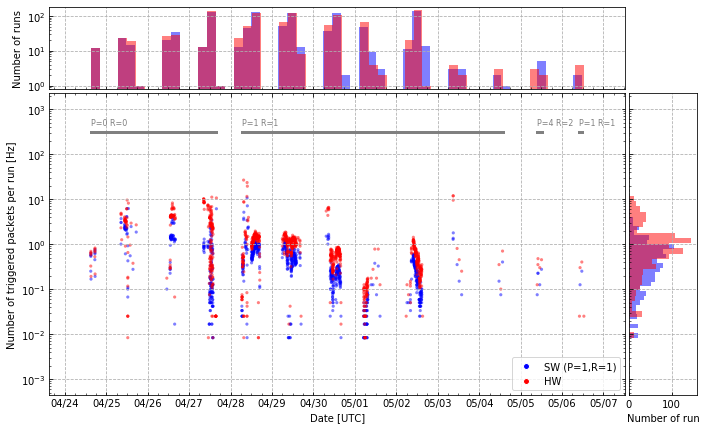

In [63]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        DATASETS_DICT[l1trg_files_bgf1_p1r1_no_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
        DATASETS_DICT[l1trg_files_bgf1_p1r1_no_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
        ylim=(10**(-2.5), 10**(2.5)),
        label='SW (P=1,R=1)', color='blue', hist_alpha=.5, scatter_alpha=.5,
        show=False
    )

vis_trigger_rate_w_distributions(
    DATASETS_DICT[hw_data_key]['lists_df']['file_trigger_datetimes'].tolist(), 
    DATASETS_DICT[hw_data_key]['lists_df']['trigger_rate_per_file'].tolist(),
    DATASETS_DICT[hw_data_key]['lists_df']['file_trigger_p_r'].tolist(),
    ylim=(10**(-2.5), 10**(2.5)), 
    label='HW',color='red', hist_alpha=.5, scatter_alpha=.5,
    base_figure_pathname=fig_path('comparison_db_bgf1_p1r1_and_hw_trg_rate_1_per_packet'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    vis_trigger_rate_kwargs={'text_params': {'fontsize':8}},
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True
);

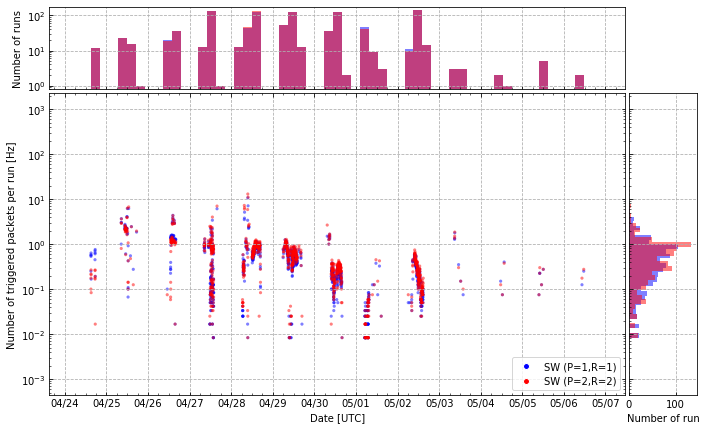

In [61]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        DATASETS_DICT[l1trg_files_bgf1_p1r1_no_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
        DATASETS_DICT[l1trg_files_bgf1_p1r1_no_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
        ylim=(10**(-2.5), 10**(2.5)),
        label='SW (P=1,R=1)', color='blue', hist_alpha=.5, scatter_alpha=.5,
        show=False
    )


vis_trigger_rate_w_distributions(
    DATASETS_DICT[unl_flight_flatmap_bgf1_key]['trigger_datetime_list'], 
    DATASETS_DICT[unl_flight_flatmap_bgf1_key]['trigger_rate_list'], 
    ylim=(10**(-2.5), 10**(2.5)), 
    label='SW (P=2,R=2)',color='red', hist_alpha=.5, scatter_alpha=.5,
    base_figure_pathname=fig_path('comparison_db_bgf1_p1r1_and_bgf1_p2r2_trg_rate_1_per_packet'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True
);

### $P=4$, $R=2$, $\textrm{bgf}=1$  without flat field map 

In [62]:
l1trg_files_bgf1_p4r2_no_flatmap_key = 'l1trg_files_bgf1_p4r2_no_flatmap'

In [ ]:
#!cat trigger_rate_for_l1trg/bg1p4r2_no_flatmapf57b7fcddde3b2444cd0e3e579e47ebf_one_trg_per_packet_128_info.txt

In [64]:
df = pd.DataFrame()
df['trigger_num_per_file'] = joblib.load('node15/trigger_rate_for_l1trg/bg1p4r2_no_flatmapf57b7fcddde3b2444cd0e3e579e47ebf_one_trg_per_packet_128_trigger_num_per_file.pkl')
df['trigger_rate_per_file'] = joblib.load('node15/trigger_rate_for_l1trg/bg1p4r2_no_flatmapf57b7fcddde3b2444cd0e3e579e47ebf_one_trg_per_packet_128_trigger_rate_per_file.pkl')
df['file_trigger_datetimes'] = joblib.load('node15/trigger_rate_for_l1trg/bg1p4r2_no_flatmapf57b7fcddde3b2444cd0e3e579e47ebf_one_trg_per_packet_128_file_trigger_datetimes.pkl')
df['file_trigger_p_r'] = joblib.load('node15/trigger_rate_for_l1trg/bg1p4r2_no_flatmapf57b7fcddde3b2444cd0e3e579e47ebf_one_trg_per_packet_128_file_trigger_p_r.pkl')
df['file_trigger_timedelta'] = joblib.load('node15/trigger_rate_for_l1trg/bg1p4r2_no_flatmapf57b7fcddde3b2444cd0e3e579e47ebf_one_trg_per_packet_128_file_trigger_timedelta.pkl')
df['file_indices'] = joblib.load('node15/trigger_rate_for_l1trg/bg1p4r2_no_flatmapf57b7fcddde3b2444cd0e3e579e47ebf_one_trg_per_packet_128_file_indices.pkl')

DATASETS_DICT[l1trg_files_bgf1_p4r2_no_flatmap_key] = {'lists_df': df}

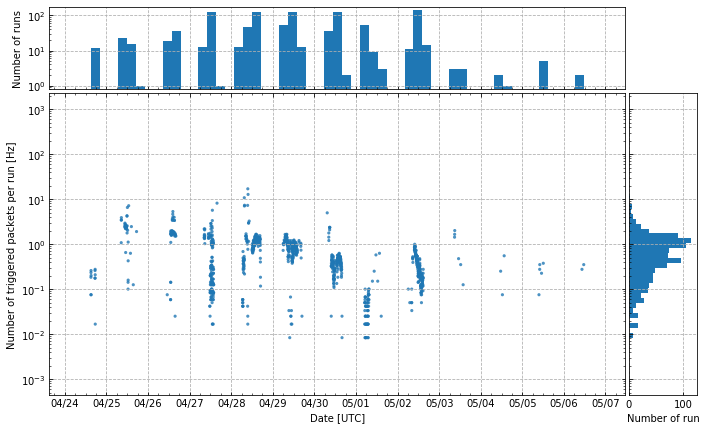

In [65]:
vis_trigger_rate_w_distributions(
    DATASETS_DICT[l1trg_files_bgf1_p4r2_no_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
    DATASETS_DICT[l1trg_files_bgf1_p4r2_no_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
    ylim=(10**(-2.5), 10**(2.5)),
    base_figure_pathname=fig_path(l1trg_files_bgf1_p4r2_no_flatmap_key + '_trg_rate_1_per_packet')
);

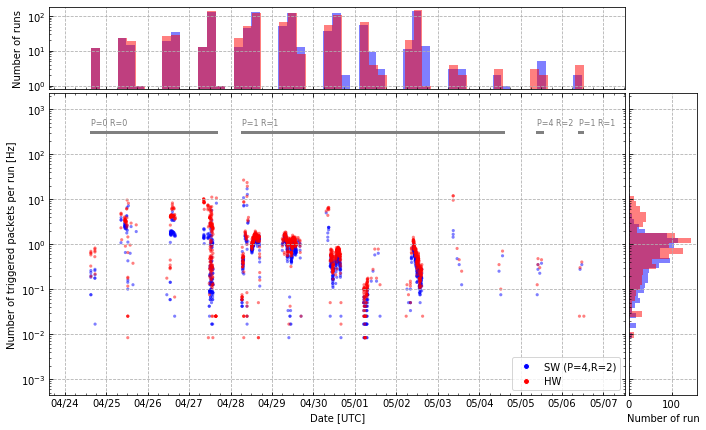

In [67]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        DATASETS_DICT[l1trg_files_bgf1_p4r2_no_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
        DATASETS_DICT[l1trg_files_bgf1_p4r2_no_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
        ylim=(10**(-2.5), 10**(2.5)),
        label='SW (P=4,R=2)', color='blue', hist_alpha=.5, scatter_alpha=.5,
        show=False
    )

vis_trigger_rate_w_distributions(
    DATASETS_DICT[hw_data_key]['lists_df']['file_trigger_datetimes'].tolist(), 
    DATASETS_DICT[hw_data_key]['lists_df']['trigger_rate_per_file'].tolist(),
    DATASETS_DICT[hw_data_key]['lists_df']['file_trigger_p_r'].tolist(),
    ylim=(10**(-2.5), 10**(2.5)), 
    label='HW',color='red', hist_alpha=.5, scatter_alpha=.5,
    base_figure_pathname=fig_path('comparison_db_bgf1_p4r2_and_hw_trg_rate_1_per_packet'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    vis_trigger_rate_kwargs={'text_params': {'fontsize':8}},
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True
);

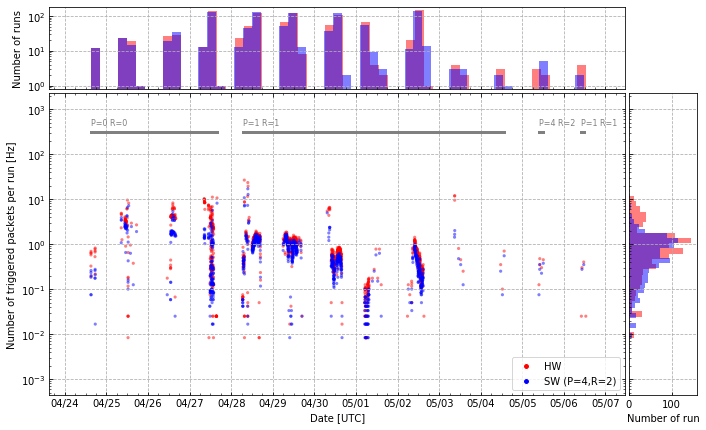

In [73]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        DATASETS_DICT[hw_data_key]['lists_df']['file_trigger_datetimes'].tolist(), 
        DATASETS_DICT[hw_data_key]['lists_df']['trigger_rate_per_file'].tolist(),
        DATASETS_DICT[hw_data_key]['lists_df']['file_trigger_p_r'].tolist(),
        ylim=(10**(-2.5), 10**(2.5)),
        label='HW',color='red', hist_alpha=.5, scatter_alpha=.5,
        vis_trigger_rate_kwargs={'text_params': {'fontsize':8}},
        show=False
    )

vis_trigger_rate_w_distributions(
    DATASETS_DICT[l1trg_files_bgf1_p4r2_no_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
    DATASETS_DICT[l1trg_files_bgf1_p4r2_no_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
    ylim=(10**(-2.5), 10**(2.5)), 
    label='SW (P=4,R=2)', color='blue', hist_alpha=.5, scatter_alpha=.5,
    base_figure_pathname=fig_path('comparison_db_bgf1_p4r2_and_hw_trg_rate_1_per_packet_blue_on_top'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True
);

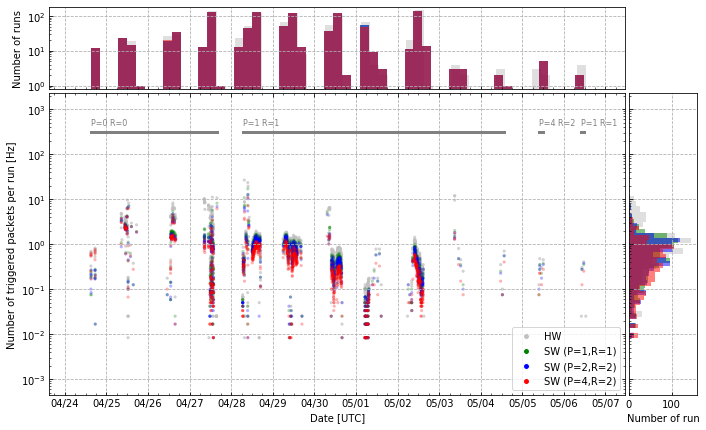

In [72]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        DATASETS_DICT[hw_data_key]['lists_df']['file_trigger_datetimes'].tolist(), 
        DATASETS_DICT[hw_data_key]['lists_df']['trigger_rate_per_file'].tolist(),
        DATASETS_DICT[hw_data_key]['lists_df']['file_trigger_p_r'].tolist(),
        ylim=(10**(-2.5), 10**(2.5)),
        label='HW', color='silver', hist_alpha=.5, scatter_alpha=.7,
        vis_trigger_rate_kwargs={'text_params': {'fontsize':8}},
        show=False
    )

fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        DATASETS_DICT[l1trg_files_bgf1_p4r2_no_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
        DATASETS_DICT[l1trg_files_bgf1_p4r2_no_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
        ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
        ylim=(10**(-2.5), 10**(2.5)),
        label='SW (P=1,R=1)', color='green', hist_alpha=.5, scatter_alpha=.3,
        show=False
    )

fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        DATASETS_DICT[l1trg_files_bgf1_no_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
        DATASETS_DICT[l1trg_files_bgf1_no_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
        ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
        ylim=(10**(-2.5), 10**(2.5)),
        label='SW (P=2,R=2)', color='blue', hist_alpha=.5, scatter_alpha=.3,
        show=False
    )

vis_trigger_rate_w_distributions(
        DATASETS_DICT[l1trg_files_bgf1_p1r1_no_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
        DATASETS_DICT[l1trg_files_bgf1_p1r1_no_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
        ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
        ylim=(10**(-2.5), 10**(2.5)), 
        label='SW (P=4,R=2)',color='red', hist_alpha=.5, scatter_alpha=.3,
        base_figure_pathname=fig_path('comparison_db_bgf1_p4r2_p2r2_p1r1_hw_trg_rate_1_per_packet_log'),
        legend=True, #legend_kwargs={'loc': 'lower right'},
        show=True
);

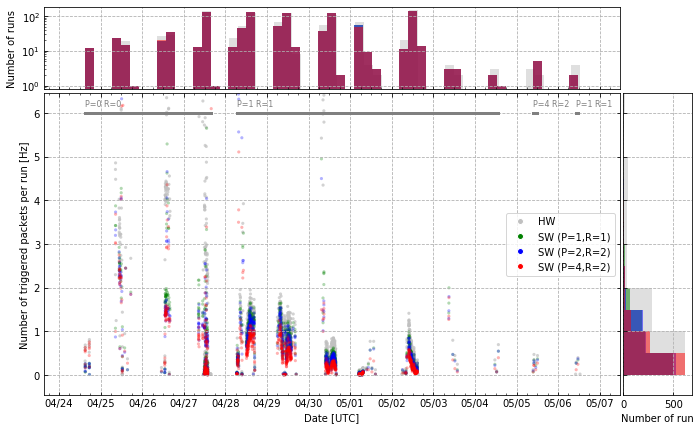

In [70]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        DATASETS_DICT[hw_data_key]['lists_df']['file_trigger_datetimes'].tolist(), 
        DATASETS_DICT[hw_data_key]['lists_df']['trigger_rate_per_file'].tolist(),
        DATASETS_DICT[hw_data_key]['lists_df']['file_trigger_p_r'].tolist(),
        ylim=(0,6), #(10**(-2.5), 10**(2.5)),
        label='HW', color='silver', hist_alpha=.5, scatter_alpha=.7,
        vis_trigger_rate_kwargs={'yscale':'linear', 'padding_fraction': .05, 'text_params': {'fontsize':8}},
        trigger_rate_hist_kwargs={'values_scale':'linear'},
        show=False
    )

fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        DATASETS_DICT[l1trg_files_bgf1_p4r2_no_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
        DATASETS_DICT[l1trg_files_bgf1_p4r2_no_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
        ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
        ylim=(0,6),#ylim=(10**(-2.5), 10**(2.5)),
        label='SW (P=1,R=1)', color='green', hist_alpha=.5, scatter_alpha=.3,
        vis_trigger_rate_kwargs={'yscale':'linear'},
        trigger_rate_hist_kwargs={'values_scale':'linear'},
        show=False
    )

fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        DATASETS_DICT[l1trg_files_bgf1_no_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
        DATASETS_DICT[l1trg_files_bgf1_no_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
        ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
        ylim=(0,6),#ylim=(10**(-2.5), 10**(2.5)),
        label='SW (P=2,R=2)', color='blue', hist_alpha=.5, scatter_alpha=.3,
        vis_trigger_rate_kwargs={'yscale':'linear'},
        trigger_rate_hist_kwargs={'values_scale':'linear'},
        show=False
    )

vis_trigger_rate_w_distributions(
        DATASETS_DICT[l1trg_files_bgf1_p1r1_no_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
        DATASETS_DICT[l1trg_files_bgf1_p1r1_no_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
        ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
        ylim=(0,6),#ylim=(10**(-2.5), 10**(2.5)), 
        label='SW (P=4,R=2)',color='red', hist_alpha=.5, scatter_alpha=.3,
        vis_trigger_rate_kwargs={'yscale':'linear'},
        trigger_rate_hist_kwargs={'values_scale':'linear'},
        base_figure_pathname=fig_path('comparison_db_bgf1_p4r2_p2r2_p1r1_hw_trg_rate_1_per_packet_linear'),
        legend=True, #legend_kwargs={'loc': 'lower right'},
        show=True
);